In [37]:
import jupyter 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.system import boot
from src.data.feature_pipeline import load_base_dataframe

# SEED ALL THE LIBS AND RETURN TORCH DEVICE
DEVICE = boot()



In [38]:
# CONSTANTS ===============================================
OHLCV_DF = load_base_dataframe()
ohlcv_df = OHLCV_DF.copy()

In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import norm, pareto, kstest
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Supondo que você já tenha um df assim:
# df: ['date', 'symbol', 'close', 'volume', 'return_1d'] (ou 'return')
df = ohlcv_df.copy()
df['date'] = pd.to_datetime(df['date'])
tickers = df['symbol'].unique()[:-2]  # Subconjunto inicial de 10

# Etapa 1: Adiciona rolling stats e detecta regime
def assign_market_regime(df, window=21):
    df = df.copy()
    df['volatility'] = df['return_1d'].rolling(window).std()
    df['mean_return'] = df['return_1d'].rolling(window).mean()
    df['volume_avg'] = df['volume'].rolling(window).mean()
    df = df.dropna()
    
    X = df[['volatility', 'mean_return', 'volume_avg']].dropna()
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
    df.loc[X.index, 'regime'] = kmeans.labels_
    
    return df



In [40]:
def fermi_dirac_pdf(x, mu, T):
    z = np.clip((x - mu) / T, -100, 100)
    return 1.0 / (np.exp(z) + 1.0)

def fermi_dirac_pdf_normalized(x, mu, T):
    pdf = fermi_dirac_pdf(x, mu, T)
    normalization = simps(pdf, x)
    return pdf / (normalization + 1e-9)

def interference_pdf(x, f1, f2, theta=0.0):
    amp1 = np.sqrt(f1(x))
    amp2 = np.sqrt(f2(x)) * np.exp(1j * theta)
    amplitude = amp1 + amp2
    prob = np.abs(amplitude)**2
    normalization = simps(prob, x)
    return prob / (normalization + 1e-9)

In [41]:
from scipy.integrate import simps
from scipy.stats import norm, pareto
from scipy.optimize import curve_fit
import numpy as np
from tqdm import tqdm
def safe_fit_data(data, mu_estimate, margin=1e-3):
    return data[np.abs(data - mu_estimate) > margin]

def bose_einstein_pdf(x, mu, T):
    z = np.clip((x - mu) / T, -100, 100)  # previne overflow
    return 1.0 / (np.exp(z) - 1.0 + 1e-9)
def bose_einstein_pdf_stabled(x, mu, T):
    z = np.clip((x - mu) / T, -100, 100)
    exp_neg_z = np.exp(-z)
    return exp_neg_z / (1 - exp_neg_z + 1e-9)

def bose_einstein_pdf_normalized(x, mu, T):
    pdf = bose_einstein_pdf(x, mu, T)
    normalization = simps(pdf, x)
    return pdf / (normalization + 1e-9)
def fit_distributions(data):
    data = data[data > 0]  # Bose-Einstein só define para valores positivos
    if len(data) < 10:
        return None  # ignora janelas pequenas

    x = np.linspace(data.min(), data.max(), 200)

    # Fit Normal
    mu_n, std_n = norm.fit(data)

    # Fit Pareto
    b, loc_p, scale_p = pareto.fit(data)

    # Fit Bose-Einstein adaptada
    try:
        mu_init = np.mean(data)
        data_safe = safe_fit_data(data, mu_init)

        params_be, _ = curve_fit(
            lambda x, mu, T: bose_einstein_pdf_normalized(x, mu, T),
            data_safe,
            np.ones_like(data_safe),
            p0=(mu_init, 0.01),
            maxfev=10000
        )
        #params_be, _ = curve_fit(
        #    lambda x, mu, T: bose_einstein_pdf_stabled(x, mu, T),
        #    data,
        #    np.ones_like(data),
        #    p0=(0.001, 0.1),
        #    maxfev=10000
        #)
    except:
        params_be = (np.nan, np.nan)

    return {
        'normal': (mu_n, std_n),
        'pareto': (b, loc_p, scale_p),
        'bose_einstein': params_be
    }
def fit_distributions_with_fd(data):
    data = data[data > 0]
    if len(data) < 10:
        return None

    x = np.linspace(data.min(), data.max(), 200)

    mu_n, std_n = norm.fit(data)
    b, loc_p, scale_p = pareto.fit(data)

    try:
        mu_init = np.mean(data)
        data_safe = data[np.abs(data - mu_init) > 1e-3]
        params_fd, _ = curve_fit(
            lambda x, mu, T: fermi_dirac_pdf_normalized(x, mu, T),
            data_safe,
            np.ones_like(data_safe),
            p0=(mu_init, 0.01),
            maxfev=10000
        )
    except:
        params_fd = (np.nan, np.nan)

    return {
        'normal': (mu_n, std_n),
        'pareto': (b, loc_p, scale_p),
        'fermi_dirac': params_fd
    }

from scipy.stats import kstest

def ks_scores(returns, fitted):
    scores = {}

    scores['ks_norm'] = kstest(returns, 'norm', args=fitted['normal']).statistic
    scores['ks_pareto'] = kstest(returns, 'pareto', args=fitted['pareto']).statistic

    if not np.isnan(fitted['bose_einstein'][0]):
        returns_pos = returns[returns > 0]
        x = np.linspace(returns_pos.min(), returns_pos.max(), 200)
        be_pdf = bose_einstein_pdf_stabled(x, *fitted['bose_einstein'])
        cdf = np.cumsum(be_pdf)
        cdf /= cdf[-1]
        def custom_cdf(val):
            return np.interp(val, x, cdf)
        scores['ks_bose_einstein'] = kstest(returns_pos, custom_cdf).statistic
    else:
        scores['ks_bose_einstein'] = np.nan

    return scores

def ks_scores_with_fd(returns, fitted):
    scores = {}
    scores['ks_norm'] = kstest(returns, 'norm', args=fitted['normal']).statistic
    scores['ks_pareto'] = kstest(returns, 'pareto', args=fitted['pareto']).statistic

    if not np.isnan(fitted['fermi_dirac'][0]):
        returns_pos = returns[returns > 0]
        x = np.linspace(returns_pos.min(), returns_pos.max(), 200)
        fd_pdf = fermi_dirac_pdf_normalized(x, *fitted['fermi_dirac'])
        cdf = np.cumsum(fd_pdf)
        cdf /= cdf[-1]
        def custom_cdf(val):
            return np.interp(val, x, cdf)
        scores['ks_fermi_dirac'] = kstest(returns_pos, custom_cdf).statistic
    else:
        scores['ks_fermi_dirac'] = np.nan

    return scores

import matplotlib.pyplot as plt

def plot_fit_example(df, ticker, regime_id):
    subset = df[df['symbol'] == ticker].copy()
    subset = assign_market_regime(subset)
    subset = subset[subset['regime'] == regime_id]
    returns = subset['return_1d'].dropna()
    returns_pos = returns[returns > 0]
    if len(returns_pos) < 10:
        print("Insufficient data.")
        return

    fitted = fit_distributions(returns)
    x = np.linspace(returns.min(), returns.max(), 200)

    plt.hist(returns, bins=50, density=True, alpha=0.5, label='Data')
    plt.plot(x, norm.pdf(x, *fitted['normal']), label='Normal')
    plt.plot(x, pareto.pdf(x, *fitted['pareto']), label='Pareto')

    if not np.isnan(fitted['bose_einstein'][0]):
        be_pdf = bose_einstein_pdf_stabled(x, *fitted['bose_einstein'])
        plt.plot(x, be_pdf, label='Bose-Einstein')

    plt.title(f'{ticker} - Regime {regime_id}')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_quantum_fit_analysis(df, tickers, regime_window=21):
    results = []
    for ticker in tqdm(tickers):
        df_ticker = df[df['symbol'] == ticker].copy()
        df_regime = assign_market_regime(df_ticker, window=regime_window)

        for regime_id in df_regime['regime'].dropna().unique():
            subset = df_regime[df_regime['regime'] == regime_id]
            returns = subset['return_1d'].dropna()
            fitted = fit_distributions(returns)
            if fitted is None: continue
            scores = ks_scores(returns, fitted)

            results.append({
                'ticker': ticker,
                'regime': int(regime_id),
                **scores
            })

    rdf= pd.DataFrame(results)
    rdf.to_csv("quantum_fit_results.csv", index=False)
    return rdf

import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import norm, pareto, kstest
from scipy.optimize import curve_fit
from scipy.integrate import simps

# ====== Distribuição Fermi-Dirac ======
def fermi_dirac_pdf(x, mu, T):
    z = np.clip((x - mu) / T, -100, 100)
    return 1.0 / (np.exp(z) + 1.0)

def fermi_dirac_pdf_normalized(x, mu, T):
    pdf = fermi_dirac_pdf(x, mu, T)
    normalization = simps(pdf, x)
    return pdf / (normalization + 1e-9)

# ====== Fit de distribuições ======
def fit_distributions_with_fd(data):
    data = data[data > 0]
    if len(data) < 10:
        return None

    x = np.linspace(data.min(), data.max(), 200)

    mu_n, std_n = norm.fit(data)
    b, loc_p, scale_p = pareto.fit(data)

    try:
        mu_init = np.mean(data)
        data_safe = data[np.abs(data - mu_init) > 1e-3]
        params_fd, _ = curve_fit(
            lambda x, mu, T: fermi_dirac_pdf_normalized(x, mu, T),
            data_safe,
            np.ones_like(data_safe),
            p0=(mu_init, 0.01),
            maxfev=10000
        )
    except:
        params_fd = (np.nan, np.nan)

    return {
        'normal': (mu_n, std_n),
        'pareto': (b, loc_p, scale_p),
        'fermi_dirac': params_fd
    }

# ====== KS-test para cada distribuição ======
def ks_scores_with_fd(returns, fitted):
    scores = {}
    scores['ks_norm'] = kstest(returns, 'norm', args=fitted['normal']).statistic
    scores['ks_pareto'] = kstest(returns, 'pareto', args=fitted['pareto']).statistic

    if not np.isnan(fitted['fermi_dirac'][0]):
        returns_pos = returns[returns > 0]
        x = np.linspace(returns_pos.min(), returns_pos.max(), 200)
        fd_pdf = fermi_dirac_pdf_normalized(x, *fitted['fermi_dirac'])
        cdf = np.cumsum(fd_pdf)
        cdf /= cdf[-1]
        def custom_cdf(val):
            return np.interp(val, x, cdf)
        scores['ks_fermi_dirac'] = kstest(returns_pos, custom_cdf).statistic
    else:
        scores['ks_fermi_dirac'] = np.nan

    return scores

# ====== Função principal ======
def run_quantum_fit_analysis_with_fd(df, tickers, assign_market_regime, regime_window=21, save_csv=True):
    results = []

    for ticker in tqdm(tickers):
        df_ticker = df[df['symbol'] == ticker].copy()
        df_regime = assign_market_regime(df_ticker, window=regime_window)

        for regime_id in df_regime['regime'].dropna().unique():
            subset = df_regime[df_regime['regime'] == regime_id]
            returns = subset['return_1d'].dropna()
            fitted = fit_distributions_with_fd(returns)
            if fitted is None: continue
            scores = ks_scores_with_fd(returns, fitted)

            results.append({
                'ticker': ticker,
                'regime': int(regime_id),
                **scores
            })

    rdf = pd.DataFrame(results)
    if save_csv:
        rdf.to_csv("quantum_fit_results_with_fd.csv", index=False)
    return rdf


In [42]:
results_df = run_quantum_fit_analysis(df,tickers)

  6%|▋         | 32/502 [05:28<54:16,  6.93s/it]  C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 16%|█▋        | 82/502 [11:47<1:09:38,  9.95s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 20%|█▉        | 100/502 [13:56<50:48,  7.58s/it] C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 39%|███▉      | 195/502 [25:11<55:51, 10.92s/it]  C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimate

In [43]:
results_df.sort_values(['ks_bose_einstein'])

,ticker,regime,ks_norm,ks_pareto,ks_bose_einstein
229,BG,1,0.412711,0.476190,0.233526
1428,WBA,1,0.422833,0.591549,0.262077
978,MSI,1,0.397135,0.505495,0.308824
92,AME,0,0.361755,0.465940,0.320152
241,CZR,1,0.410568,0.529851,0.328136
...,...,...,...,...,...
1453,WST,2,0.348037,0.471800,NaN
1459,WY,2,0.352361,0.462224,NaN
1470,WDAY,2,0.357416,0.494320,NaN
1478,XEL,2,0.438307,0.454545,NaN


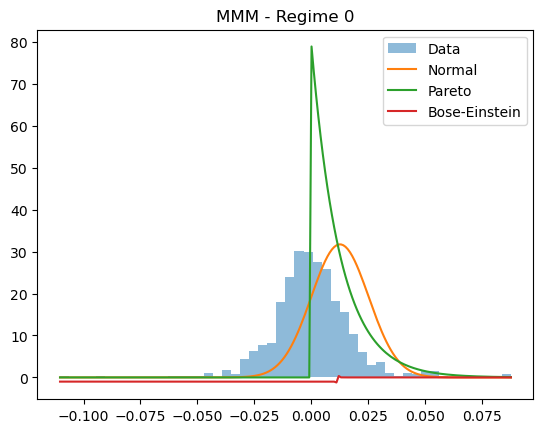

In [44]:


# Opcional: plotar histogramas + densidade para um exemplo
def plot_fit_example(ticker, regime_id):
    subset = df[(df['symbol'] == ticker)].copy()
    subset = assign_market_regime(subset)
    subset = subset[subset['regime'] == regime_id]
    returns = subset['return_1d'].dropna()

    fitted = fit_distributions(returns)

    x = np.linspace(min(returns), max(returns), 200)
    plt.hist(returns, bins=50, density=True, alpha=0.5, label='Data')
    plt.plot(x, norm.pdf(x, *fitted['normal']), label='Normal')
    plt.plot(x, pareto.pdf(x, *fitted['pareto']), label='Pareto')
    if not np.isnan(fitted['bose_einstein'][0]):
        plt.plot(x, bose_einstein_pdf(x, *fitted['bose_einstein']), label='Bose-Einstein')
    plt.title(f'{ticker} - Regime {regime_id}')
    plt.legend()
    plt.show()

# Exemplo:
plot_fit_example(ticker=tickers[0], regime_id=0)


In [45]:
fd_results_df = run_quantum_fit_analysis_with_fd(df,tickers,assign_market_regime)

  0%|          | 0/502 [00:00<?, ?it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  0%|          | 1/502 [00:00<02:35,  3.21it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  0%|          | 2/502 [00:00<03:21,  2.48it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimat

  5%|▍         | 25/502 [01:02<18:06,  2.28s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  5%|▌         | 26/502 [01:06<22:17,  2.81s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  5%|▌         | 27/502 [01:09<22:34,  2.85s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  6%|▌         | 28/502 [01:09<16:40,  2.11s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warni

 10%|▉         | 49/502 [01:45<11:20,  1.50s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 10%|▉         | 50/502 [01:45<08:36,  1.14s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 10%|█         | 51/502 [01:45<0

 14%|█▎        | 69/502 [02:15<15:16,  2.12s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 14%|█▍        | 71/502 [02:40<47:13,  6.57s/it]  C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 14%|█▍        | 72/502 [02:41<35:04,  4.89s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 15%|█▍        | 73/502 [02:47<38:22,  5.37s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  war

 19%|█▊        | 94/502 [03:37<13:05,  1.92s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 19%|█▉        | 95/502 [03:41<17:29,  2.58s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 19%|█▉        | 97/502 [03:43<12:20,  1.83s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 20%|█▉        | 98/502 [03:44<11:25,  1.70s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warni

 24%|██▍       | 121/502 [05:12<07:18,  1.15s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 24%|██▍       | 122/502 [05:14<09:05,  1.44s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 25%|██▍       | 123/502 [05:27<30:51,  4.89s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 30%|██▉       | 150/502 [05:50<03:05,  1.90it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 30%|███       | 151/502 [05:50<02:54,  2.01it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 30%|███       | 152/502 [05:51<02:45,  2.12it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

 35%|███▍      | 175/502 [06:48<18:26,  3.38s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 35%|███▌      | 176/502 [06:48<13:40,  2.52s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 35%|███▌      | 178/502 [06:4

 40%|███▉      | 200/502 [07:10<06:06,  1.21s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 40%|████      | 201/502 [07:14<09:29,  1.89s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 40%|████      | 202/502 [07:14<07:16,  1.45s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

 46%|████▌     | 231/502 [08:00<10:27,  2.32s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 46%|████▌     | 232/502 [08:17<29:02,  6.45s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 46%|████▋     | 233/502 [08:19<23:12,  5.18s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 51%|█████     | 257/502 [09:11<09:11,  2.25s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 51%|█████▏    | 258/502 [09:12<06:38,  1.63s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 52%|█████▏    | 260/502 [09:2

 57%|█████▋    | 286/502 [11:17<07:32,  2.10s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 57%|█████▋    | 287/502 [11:17<05:38,  1.57s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 57%|█████▋    | 288/502 [11:18<04:17,  1.20s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 62%|██████▏   | 312/502 [11:38<02:44,  1.16it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 62%|██████▏   | 313/502 [11:38<02:12,  1.42it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 63%|██████▎   | 314/502 [11:3

 67%|██████▋   | 336/502 [12:15<04:09,  1.51s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 67%|██████▋   | 337/502 [12:17<05:03,  1.84s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 67%|██████▋   | 338/502 [12:18<03:55,  1.44s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

 72%|███████▏  | 359/502 [12:43<01:13,  1.94it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 72%|███████▏  | 360/502 [12:44<01:13,  1.92it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 72%|███████▏  | 362/502 [12:44<00:54,  2.55it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

 78%|███████▊  | 390/502 [13:14<00:49,  2.27it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 78%|███████▊  | 391/502 [13:15<00:43,  2.55it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 78%|███████▊  | 392/502 [13:15<00:38,  2.88it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

 83%|████████▎ | 415/502 [14:17<01:41,  1.17s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 83%|████████▎ | 416/502 [14:20<02:49,  1.97s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 83%|████████▎ | 417/502 [14:21<02:04,  1.46s/it]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 89%|████████▉ | 449/502 [15:06<00:52,  1.01it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 90%|████████▉ | 450/502 [15:06<00:41,  1.27it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 90%|████████▉ | 451/502 [15:0

 94%|█████████▍| 474/502 [15:37<00:26,  1.05it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 95%|█████████▍| 475/502 [15:38<00:20,  1.34it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 95%|█████████▍| 476/502 [15:38<00:15,  1.68it/s]C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could 

100%|██████████| 502/502 [16:17<00:00,  1.95s/it]


In [46]:
fd_results_df

,ticker,regime,ks_norm,ks_pareto,ks_fermi_dirac
0,MMM,0,0.392543,0.519941,0.861208
1,MMM,2,0.366976,0.498010,0.890780
2,AOS,2,0.429205,0.563981,0.839911
3,AOS,0,0.394256,0.495214,0.847881
4,AOS,1,0.421004,0.503788,0.475240
...,...,...,...,...,...
1486,ZBRA,1,0.388644,0.520388,0.779832
1487,ZBRA,0,0.370332,0.456885,0.426883
1488,ZBH,1,0.401402,0.495627,0.473752
1489,ZBH,2,0.349643,0.424242,0.256410


In [47]:
import matplotlib.pyplot as plt

def plot_fit_fd(df, ticker, regime_id, assign_market_regime):
    subset = df[df['symbol'] == ticker].copy()
    subset = assign_market_regime(subset)
    subset = subset[subset['regime'] == regime_id]
    returns = subset['return_1d'].dropna()
    returns_pos = returns[returns > 0]

    if len(returns_pos) < 10:
        print("Insufficient data.")
        return

    fitted = fit_distributions_with_fd(returns)
    x = np.linspace(returns.min(), returns.max(), 200)

    plt.hist(returns, bins=50, density=True, alpha=0.5, label='Data')
    plt.plot(x, norm.pdf(x, *fitted['normal']), label='Normal')
    plt.plot(x, pareto.pdf(x, *fitted['pareto']), label='Pareto')

    if not np.isnan(fitted['fermi_dirac'][0]):
        fd_pdf = fermi_dirac_pdf_normalized(x, *fitted['fermi_dirac'])
        plt.plot(x, fd_pdf, label='Fermi-Dirac', color='red')

    plt.title(f'{ticker} - Regime {regime_id} (Fermi-Dirac Fit)')
    plt.legend()
    plt.grid(True)
    plt.show()


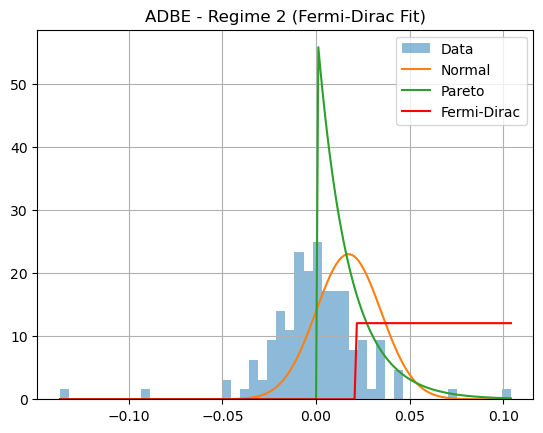

In [48]:
plot_fit_fd(df, ticker="ADBE", regime_id=2, assign_market_regime=assign_market_regime)
